In [4]:
%autoreload 2
%matplotlib inline

In [5]:
import pandas as pd
from astropy.io import fits

In [6]:
from astropy.coordinates import SkyCoord

In [7]:
import astropy.wcs.wcs as wcs
import matplotlib.pyplot as plt

In [8]:
from collections import OrderedDict

# Initialize data directory

In [9]:
path = "../../Data/"

# Data massaging

-[x] combine table so we don't have to deal with several copies of the table  


In [10]:
dataPath = path + "Subaru_data/" 

See how to convert FITS record array to pandas dataframe for easy manipulation
in `preprocess.py`

In [11]:
bands = ["I", "R", "G"]

In [12]:
cats = OrderedDict({})
wcs_dict = OrderedDict({})
df_dict = OrderedDict({})
for band in ["I", "R", "G"]:
    cats[band] = fits.open(dataPath + "{0}.cat".format(band))
    # don't need wcs_dict if no wcs coord transformation is done
    # wcs_dict[band] = wcs.WCS(cats[band][0].header) 
    df_dict[band] = pd.read_hdf(dataPath + "preprocessed_subaru_cat.h5", 
                                band + "_data")
    df_dict[band].columns = ["{0}band_".format(band) + col 
                             for col in df_dict[band].columns]

## load Rshape catalog

In [13]:
Rshape = fits.open(dataPath + "R.shape")
Rshapes = pd.DataFrame(Rshape[1].data.tolist(),
                       columns=Rshape[1].data.dtype.names)

## see if wcs_coords tells us if the objects are the same across catalogs

In [14]:
wcs_keys = ['X_WORLD', u'Y_WORLD']

In [15]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["G"][["Gband_" + k for k in wcs_keys]])

Gband_X_WORLD   NaN
Gband_Y_WORLD   NaN
Iband_X_WORLD   NaN
Iband_Y_WORLD   NaN
dtype: float64

In [16]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["R"][["Rband_" + k for k in wcs_keys]])

Iband_X_WORLD   NaN
Iband_Y_WORLD   NaN
Rband_X_WORLD   NaN
Rband_Y_WORLD   NaN
dtype: float64

seems like the coords already show objects in the correct order

In [17]:
df_dict["I"][["Iband_" + k for k in wcs_keys]].iloc[0]

Iband_X_WORLD    268.146518
Iband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [18]:
df_dict["G"][["Gband_" + k for k in wcs_keys]].iloc[0]

Gband_X_WORLD    268.146518
Gband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [19]:
df_dict["R"][["Rband_" + k for k in wcs_keys]].iloc[0]

Rband_X_WORLD    268.146518
Rband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [20]:
for band in ["R", "G", "I"]:
    print df_dict[band].shape[0]

100680
100680
100680


seems like it is true that the objects are already aligned 

In [21]:
np.sum(df_dict["R"]["Rband_FLUX_RADIUS"] - Rshapes["FLUX_RADIUS"])

0.0

In [22]:
combined_cat = pd.concat([Rshapes, df_dict["R"], df_dict["I"], df_dict["G"]], 
                         axis=1)

# correct for magnitude zero points 

see https://github.com/MCTwo/SuprimeCam/blob/master/Reduction%20Notes/2014A_zeropoints.md
for correction values that Will found out

In [23]:
bands = [k for k in combined_cat.keys() if "_MAG_" in k]

In [24]:
correction = {"G": 27.368,
              "R": 27.683, 
              "I": 27.573}

It is ridiculous to have 99 to be in the data so we replace it.

In [25]:
combined_cat[bands] = combined_cat[bands].replace(99, np.nan)

In [26]:
for k, v in correction.iteritems():
    for bandtype in ["ISO", "APER", "AUTO"]:
        combined_cat["{0}band_MAG_{1}".format(k, bandtype)] += correction[k]

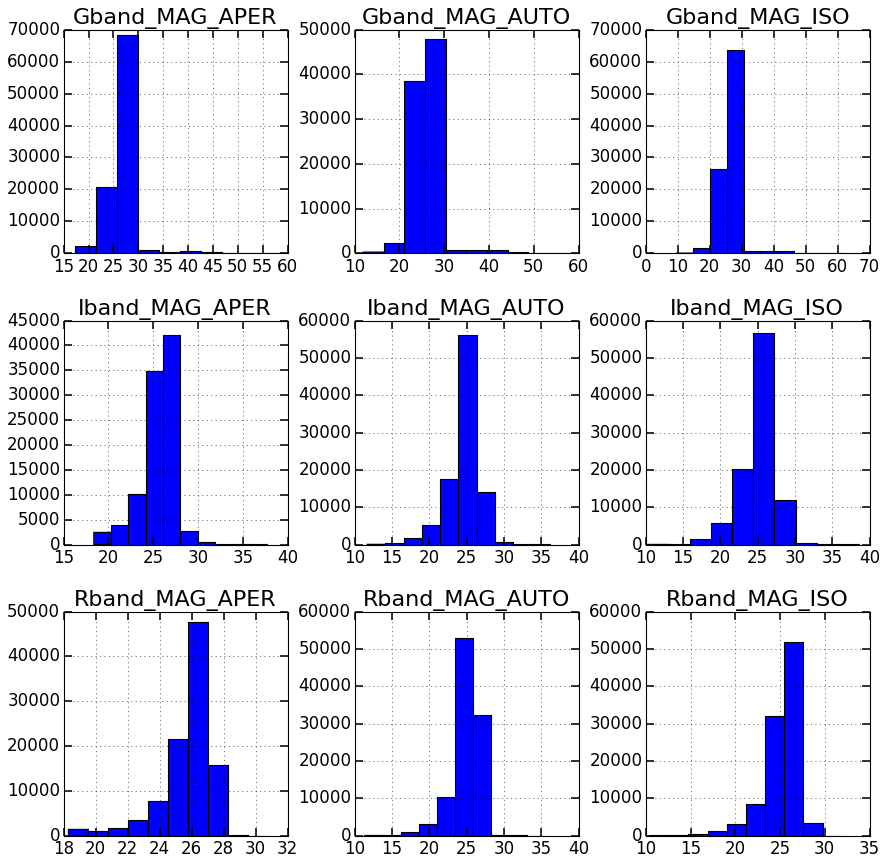

In [27]:
_ = combined_cat[bands].hist(figsize=(13, 13))

In [28]:
combined_cat[bands].describe()

,Rband_MAG_ISO,Rband_MAG_APER,Rband_MAG_AUTO,Iband_MAG_ISO,Iband_MAG_APER,Iband_MAG_AUTO,Gband_MAG_ISO,Gband_MAG_APER,Gband_MAG_AUTO
count,100676.000000,100618.000000,100171.000000,97124.000000,96885.000000,96109.000000,94514.000000,94465.000000,91682.000000
mean,25.220124,25.739510,24.893587,25.123682,25.594841,24.678227,26.324997,26.767204,25.934084
std,1.973462,1.595199,1.808283,2.282723,1.891035,2.066691,3.126075,2.985668,2.957659
min,10.474344,18.294856,11.353675,10.246561,18.370000,11.657694,9.683485,17.380695,11.890137
25%,24.461239,25.247515,24.287714,24.106869,24.897884,23.834921,25.126403,25.823300,24.890356
50%,25.642054,26.180871,25.320177,25.549238,26.010667,25.073795,26.289683,26.676378,25.886930
75%,26.558134,26.793240,26.065320,26.619803,26.729438,25.960705,27.310435,27.385130,26.748980
max,31.875740,30.748899,35.502136,38.562045,37.696493,36.155067,62.045269,59.399376,57.968651


# also do area cut!

center at the Subaru pointing center as documented in the file
`wittman-v2.1ope`

In [3]:
center_wcs = SkyCoord("17h52m06.0s", "44d41m00.0s")

In [35]:
center_wcs_ra = center_wcs.ra.degree
center_wcs_dec = center_wcs.dec.degree

In [41]:
dist = np.sqrt((combined_cat.Rband_X_WORLD - center_wcs_ra) ** 2 + \
    (combined_cat.Rband_Y_WORLD - center_wcs_dec) ** 2)
dist *= 60  # convert to arcmins

In [44]:
mask = np.array(dist < 15)

In [47]:
combined_cat = combined_cat[mask]

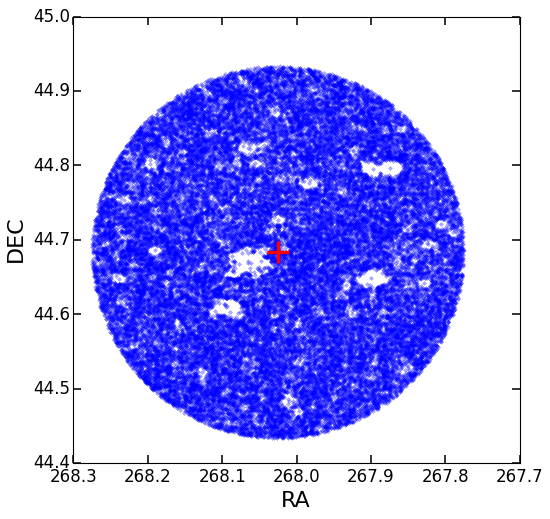

In [57]:
plt.axes().set_aspect('equal')
plt.plot(combined_cat.Rband_X_WORLD, 
         combined_cat.Rband_Y_WORLD, '.', alpha=0.3)
plt.plot(center_wcs.ra.degree, 
         center_wcs.dec.degree, 
         'r+', ms=20, mew=3)
plt.xlim(plt.xlim()[::-1])  # invert x axis
xticks, _ = plt.xticks()
_ = plt.xticks(xticks, [str(t) for t in xticks])
plt.xlabel("RA")
plt.ylabel("DEC")

(obsolete) recalculate where to cut ... ref: van Weeren 2012 Fig. 1

```Python
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")

ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_X_WORLD > ra_lower, 
        combined_cat.Rband_X_WORLD < ra_upper)]
combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_Y_WORLD > dec_lower,
        combined_cat.Rband_Y_WORLD < dec_upper)]

plt.plot(combined_cat.Rband_X_WORLD, 
         combined_cat.Rband_Y_WORLD, '.', alpha=0.3)
```

# save combined cat before preprocessing

In [54]:
combined_cat.to_hdf(dataPath + "combined_cat.h5", "preprocess_df")